### Importing packages

In [1]:
import os
import re
import math
import pickle
from joblib import Parallel, delayed
from tqdm import tqdm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas
import seaborn as sns
from scipy import stats
import networkx as nx
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from itertools import combinations, chain
import vectorbt as vbt
import textwrap
from rapidfuzz.fuzz import ratio
from sklearn.preprocessing import StandardScaler

import warnings
warnings.filterwarnings("ignore")

### Helper Functions

In [2]:
%run "../utils/functions.py"

### Load data

In [3]:
with open(
    file="../data/coin_px_vol_2022-06-24_to_2025-06-24.pkl", 
    mode="rb"
    ) as f:
    data_dict = pickle.load(f)

coin_prices = pd.concat(
    [
        data_dict[i]["price"] for i in data_dict
    ],
    axis=1
)

coin_prices.columns = [i for i in data_dict]

coin_prices = coin_prices.dropna(
    axis = 1,
    thresh = 0.99 * coin_prices.shape[0]
).ffill(limit=2).replace(np.nan, 0)

coin_prices.tail(4)

,SOL,BTC,XRP,DOGE,ETH,ADA,BNB,TRX,AAVE,UNI,...,BICO,FIST,GMX,BAND,LRC,RARE,SKL,TWT,HNT,PHB
date,,,,,,,,,,,,,,,,,,,,,
2025-06-21,140.061295,103290.105145,2.120113,0.162332,2403.607721,0.576848,641.466075,0.272483,247.264404,7.073481,...,0.089715,0.321726,14.070058,0.584629,0.075146,0.048383,0.017951,0.722245,2.428924,0.414596
2025-06-22,133.866437,101532.568385,2.044380,0.153080,2277.899190,0.550708,626.568767,0.270289,231.713187,6.388992,...,0.085296,0.437483,13.186598,0.550390,0.071409,0.044991,0.016872,0.684994,2.251220,0.385577
2025-06-23,132.210728,100852.582646,2.013513,0.151148,2229.907577,0.541130,615.920084,0.263612,227.555713,6.260848,...,0.082184,0.434130,12.899459,0.520715,0.069055,0.043732,0.016632,0.669218,2.171437,0.374358
2025-06-24,144.786261,105511.624379,2.164008,0.164473,2422.994920,0.583240,640.254318,0.273023,258.018653,6.830906,...,0.093872,0.448770,14.122592,0.588557,0.077711,0.048367,0.018450,0.712156,2.355143,0.425652


### Rolling Validation Splits for Pairs Trading Strategy

In [4]:
n_splits = 20

# Generate and capture the figure
fig = coin_prices.vbt.rolling_split(
    n=n_splits,
    window_len=455,
    set_lens=(90,),
    left_to_right=False,
    plot=True
)

# Clean it up with just a few tweaks
fig.update_layout(
    title="Fig 1. Rolling Validation Splits for Pairs Trading Strategy (365 Days Train / 90 Days Test)",
    font=dict(size=12),
    xaxis_title="Date",
    yaxis_title="Split Index",
    height=400,
    width=800,
    margin=dict(l=30, r=30, t=60, b=30)  # Padding inside border
)

FigureWidget({
    'data': [{'colorscale': [[0.0, '#1f77b4'], [1.0, '#1f77b4']],
              'hoverongaps': False,
              'name': '0',
              'showlegend': True,
              'showscale': False,
              'type': 'heatmap',
              'uid': '7866715e-10c7-4b0f-8078-9a9fcd786573',
              'x': array([datetime.datetime(2022, 6, 25, 0, 0),
                          datetime.datetime(2022, 6, 26, 0, 0),
                          datetime.datetime(2022, 6, 27, 0, 0), ...,
                          datetime.datetime(2025, 6, 22, 0, 0),
                          datetime.datetime(2025, 6, 23, 0, 0),
                          datetime.datetime(2025, 6, 24, 0, 0)], shape=(1097,), dtype=object),
              'y': array([19, 18, 17, 16, 15, 14, 13, 12, 11, 10,  9,  8,  7,  6,  5,  4,  3,  2,
                           1,  0]),
              'z': array([[nan, nan, nan, ..., nan, nan, nan],
                          [nan, nan, nan, ..., nan, nan, nan],
              

In [5]:
n_splits = 20

splits = coin_prices.vbt.rolling_split(
    n=n_splits,
    window_len=455,
    set_lens=(365,)
)

(in_price, in_indexes), (out_price, out_indexes) = splits

Selected 20 Pairs for Backtesting Period 1: (BORA, AXS)  (ENJ, BICO)  (ZEC, BSV)  (ZEN, BSW)  (BTCB, BTC.B)  (IOTA, CRO)  (MANA, ENJ)  (STMX, IOTA)  (CRO, KAVA)  (CELO, KSM)  (ORBS, MANA)  (BSW, PRO)  (YGG, RARE)  (OM, STMX)  (ZIL, STORJ)
(DOT, THETA)  (GMT, WAVES)  (1INCH, WIN)  (FLOW, ZEN)  (BAT, ZIL)

----------------------------------------------------------------------------------------------------------------------------------------------------------------
Selected 22 Pairs for Backtesting Period 2: (BORA, BAT)  (THETA, BICO)  (AIOZ, BSW)  (IOTA, CRO)  (MANA, ENJ)  (SAND, GMT)  (CRO, HNT)  (GMT, IOTA)  (CELO, KSM)  (WAVAX, MANA)  (STORJ, RARE)  (OM, SAND)  (BTC.B, STETH)  (XTZ, STORJ)  (DOT,
THETA)  (JST, VET)  (RAY, WAVES)  (BAT, WIN)  (FLOW, XTZ)  (AXS, YGG)  (BTT, ZEC)  (ZEC, ZEN)

----------------------------------------------------------------------------------------------------------------------------------------------------------------
Selected 18 Pairs for Backtesting Per

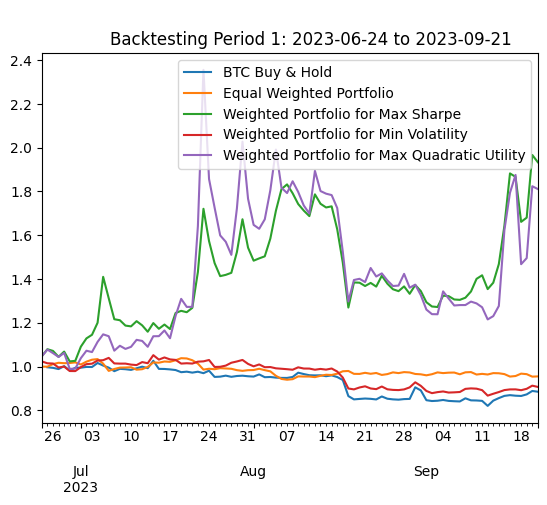

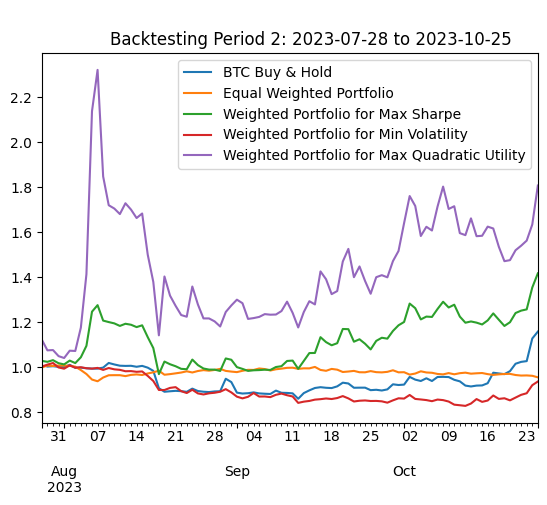

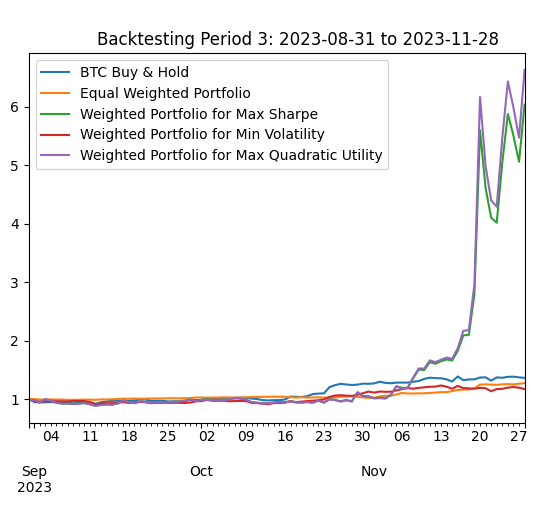

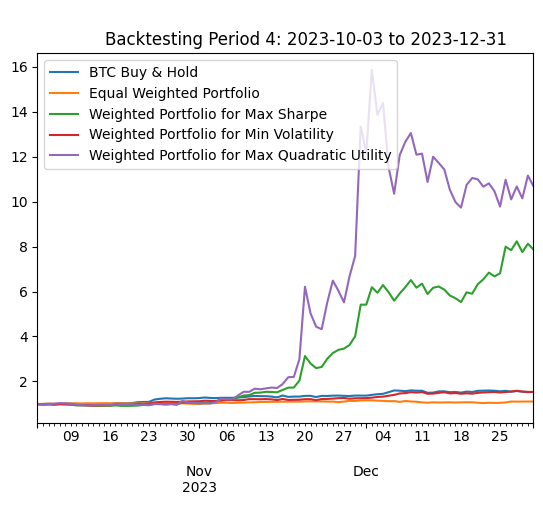

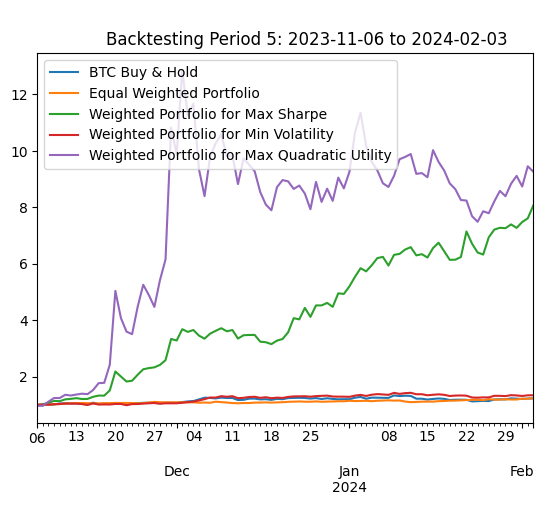

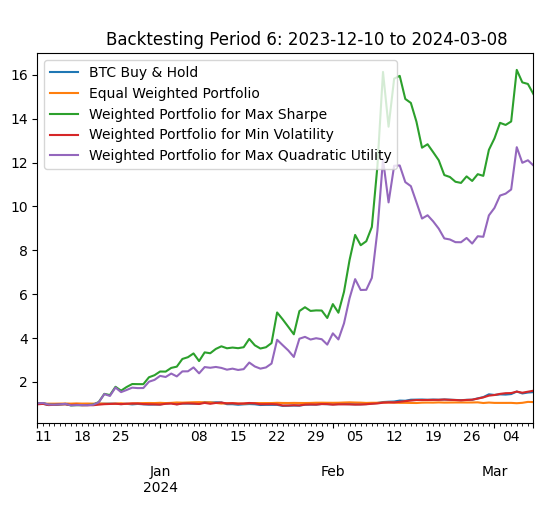

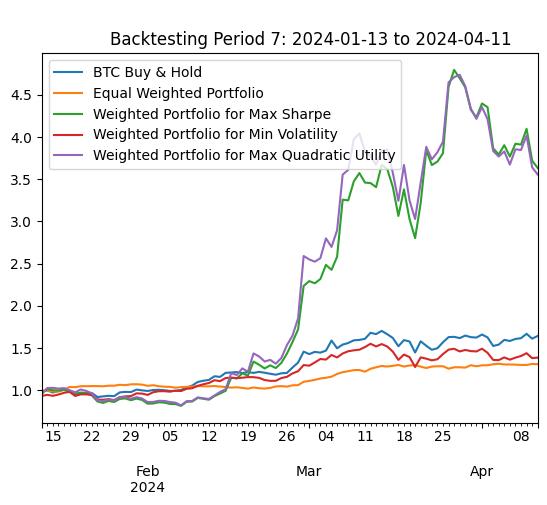

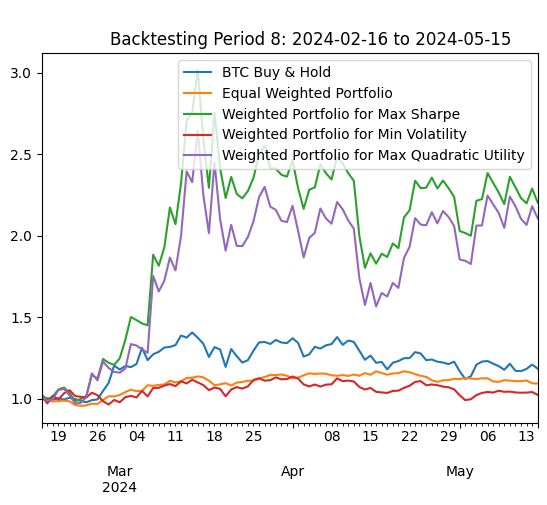

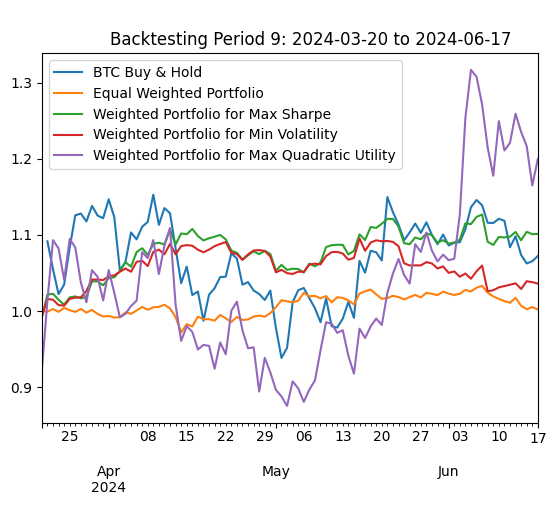

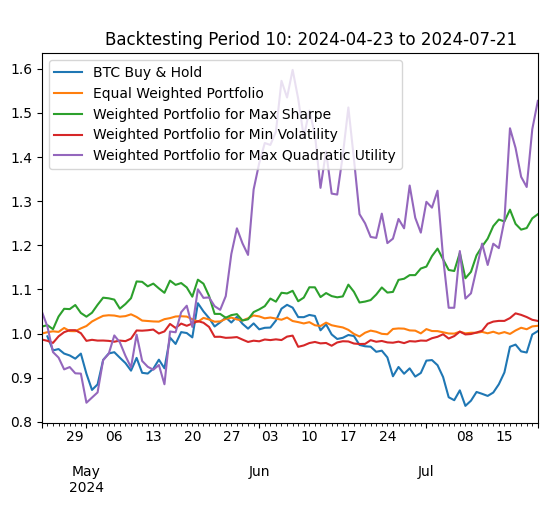

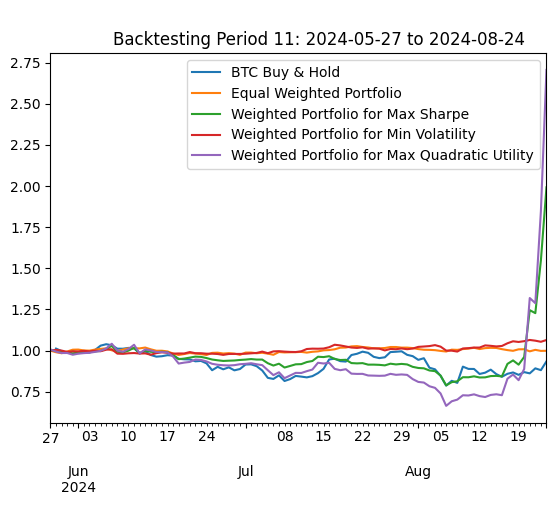

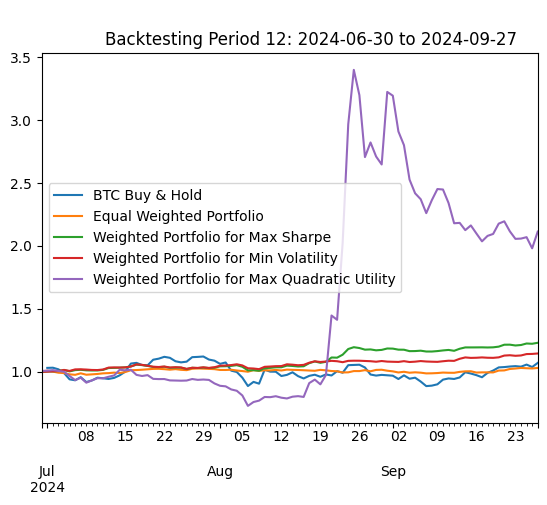

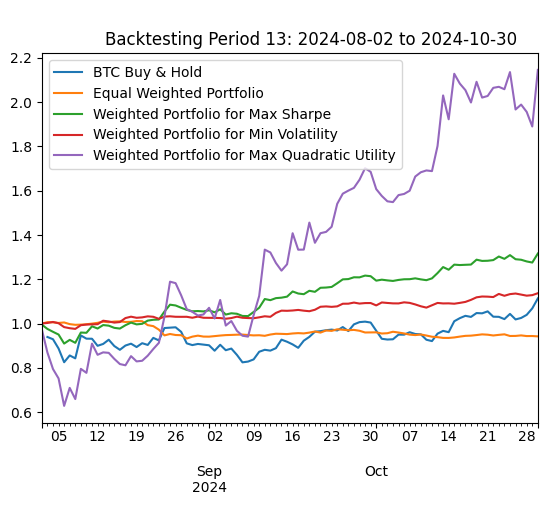

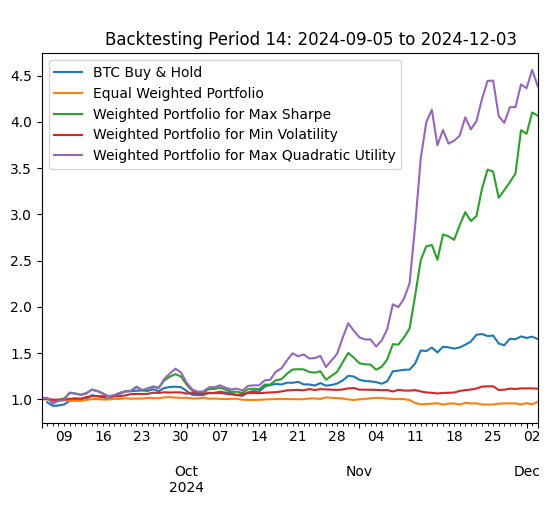

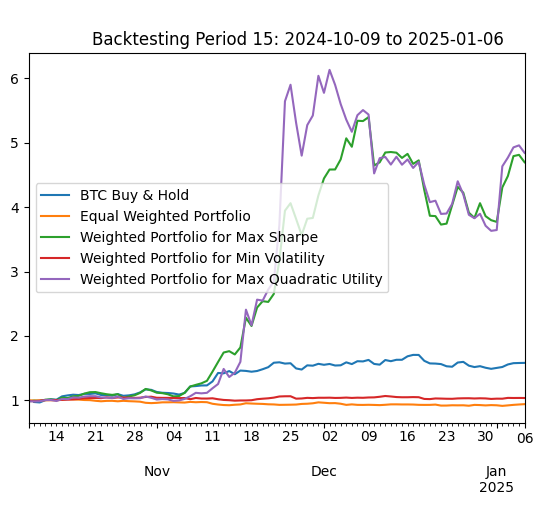

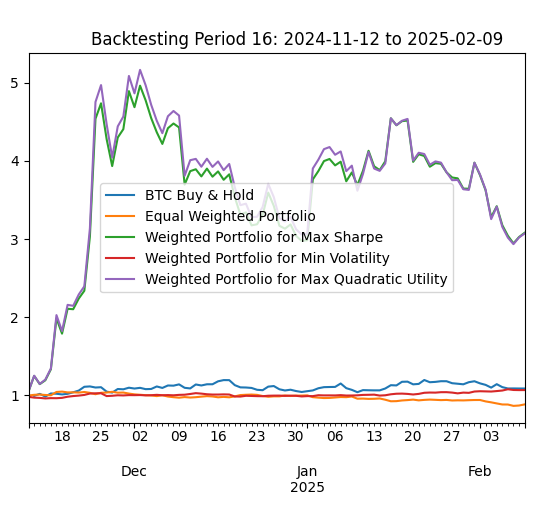

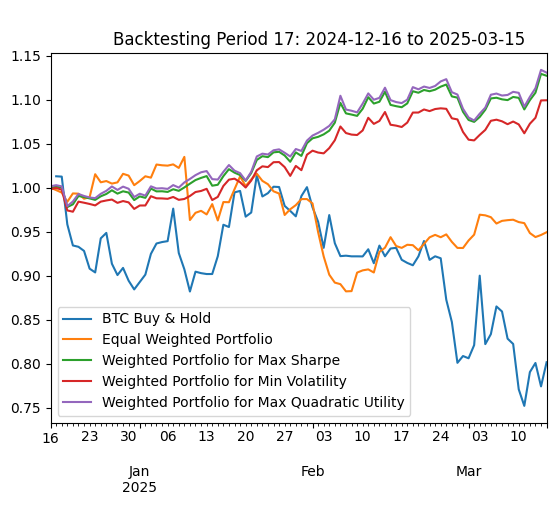

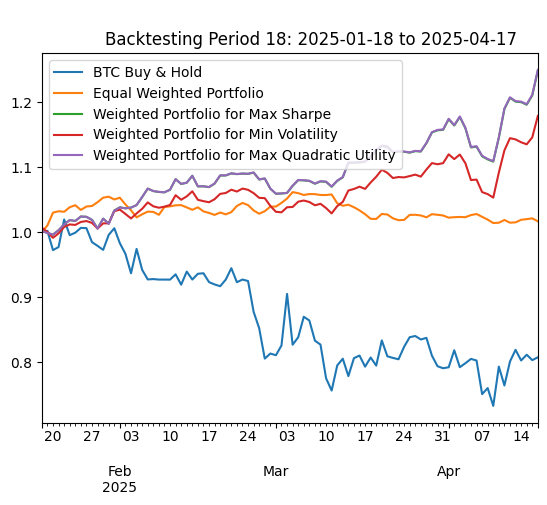

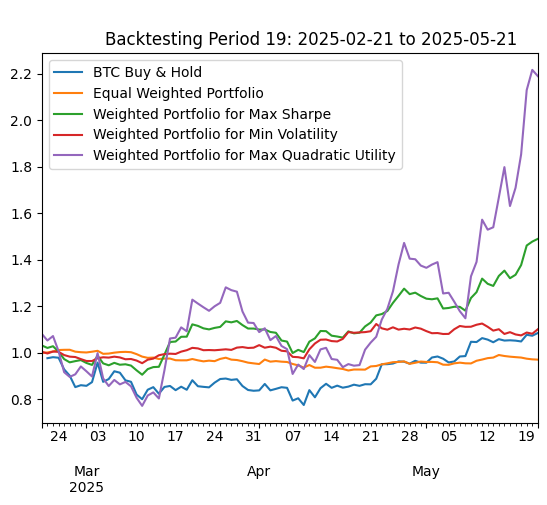

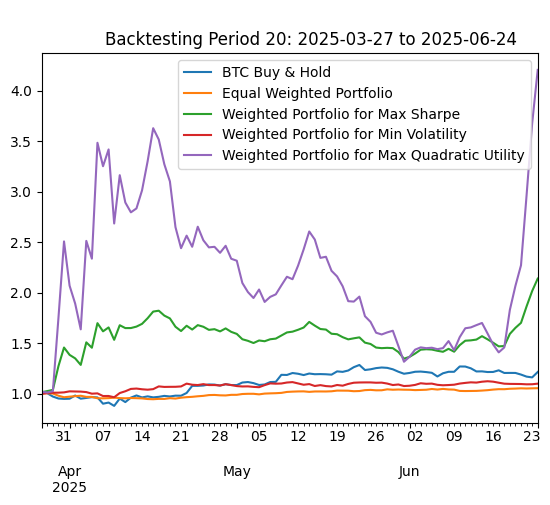

In [105]:
performance_stats = []
plots = []

for indic in range(n_splits):
    train = in_price[indic].set_index(in_indexes[indic])
    test = out_price[indic].set_index(out_indexes[indic])

    scaler = StandardScaler()

    train_norm = pd.DataFrame(
        data=scaler.fit_transform(train), 
        columns=train.columns, 
        index=train.index
    )

    test_norm = pd.DataFrame(
        data=scaler.fit_transform(test), 
        columns=test.columns, 
        index=test.index
    )

    final_pairs = get_cointegrated_pairs(prices=train_norm)

    print(f"Selected {len(final_pairs)} Pairs for Backtesting Period {indic+1}:", textwrap.fill("  ".join([f"({a}, {b})" for a, b in final_pairs]), width=200))
    print("\n"+"----------------"*10)

    rolling_params = get_rolling_signals(
        prices=coin_prices, 
        select_pairs=final_pairs
    )

    all_positions = get_long_short_signals(
        prices=test_norm, 
        select_pairs=final_pairs, 
        rolling_params=rolling_params, 
        threshold=0.5
    )

    out_sample_returns = coin_prices.pct_change().loc[
        test_norm.index[0]:test_norm.index[-1]
    ][all_positions.columns]

    baseline_strategy_btc_hold = test["BTC"].pct_change().rename("BTC Buy & Hold")
    net_returns = (all_positions.shift() * out_sample_returns).sum(axis=1).rename("Equal Weighted Portfolio")
    max_sharpe_weighted_port_returns = optimal_portfolio_weights(returns=out_sample_returns, objective="max_sharpe")
    min_volatility_weighted_port_returns = optimal_portfolio_weights(returns=out_sample_returns, objective="min_volatility")
    max_quad_weighted_port_returns = optimal_portfolio_weights(returns=out_sample_returns, objective="max_quad")

    all_strat_net_daily_returns = pd.concat(
        [
            baseline_strategy_btc_hold,
            net_returns, 
            max_sharpe_weighted_port_returns, 
            min_volatility_weighted_port_returns, 
            max_quad_weighted_port_returns
        ], 
        axis=1
    )

    plots.append((1 + all_strat_net_daily_returns).cumprod().plot(
        title=f"""
        Backtesting Period {indic+1}: {str(test.index.min().date())} to {str(test.index.max().date())}"""
    ));

    performance_stats.append(all_strat_net_daily_returns.drop(columns="BTC Buy & Hold").apply(
        lambda strat_returns: compute_performance_metrics(
            strategy_returns=strat_returns, 
            benchmark_returns=all_strat_net_daily_returns["BTC Buy & Hold"]
        ),
        axis=0
    ).T
    )

In [106]:
pd.concat(performance_stats, axis=0).reset_index().rename(columns={"index":"Strategy"}).groupby("Strategy").mean()

,Holding Period (Days),Holding Period (Months),Holding Period (Years),Cumulative Return,Annualized Return,Annualized Volatility,Sharpe Ratio,Sortino Ratio,Max Drawdown,Win Rate,Avg Win,Avg Loss,Profit Factor,Alpha,Beta,R-squared
Strategy,,,,,,,,,,,,,,,,
Equal Weighted Portfolio,90.0,4.29,0.36,0.039679,0.149496,0.127524,0.639285,1.475904,-0.073293,0.521111,0.005942,-0.005874,1.224633,0.127198,0.001778,0.055734
Weighted Portfolio for Max Quadratic Utility,90.0,4.29,0.36,2.924659,139.795651,1.371972,2.894188,7.915992,-0.340606,0.515556,0.065545,-0.035278,1.959899,3.436475,0.993821,0.162385
Weighted Portfolio for Max Sharpe,90.0,4.29,0.36,2.552140,152.235239,0.808713,3.578736,8.643302,-0.198898,0.549444,0.040621,-0.021573,2.179147,2.533769,0.719499,0.189880
Weighted Portfolio for Min Volatility,90.0,4.29,0.36,0.150610,0.573145,0.199995,1.864083,2.952727,-0.081773,0.556667,0.009736,-0.009169,1.413641,0.160097,0.330180,0.354478


# Plots and Figures

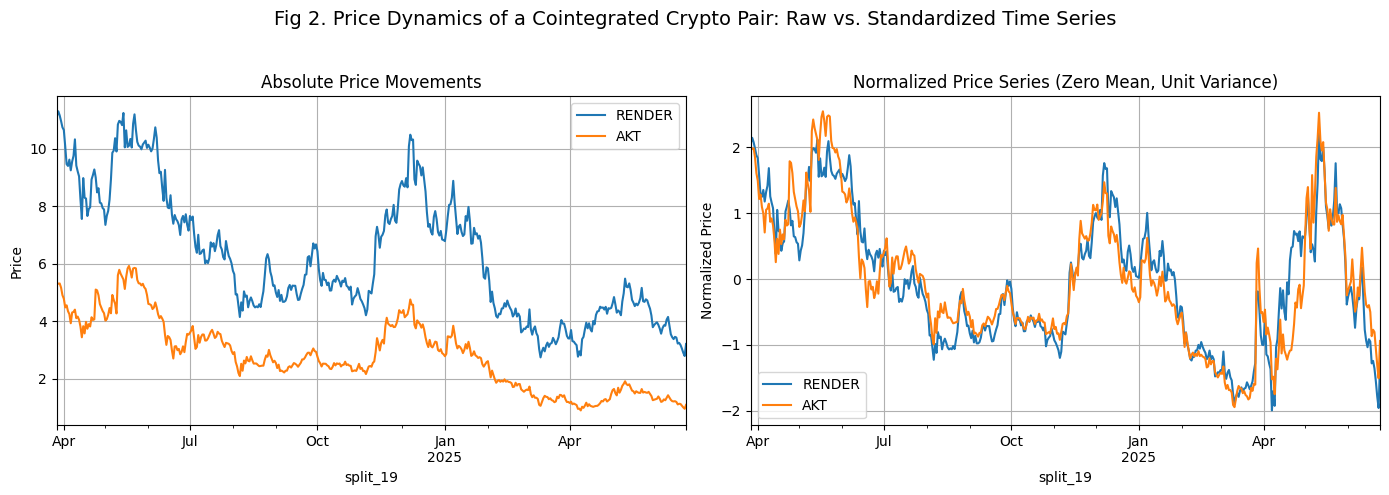

In [107]:
comparison_absolute_vs_norm_prices(
    pairs_list=final_pairs[0], 
    train=pd.concat([train, test], axis=0), 
    train_norm=pd.concat([train_norm, test_norm], axis=0)
)

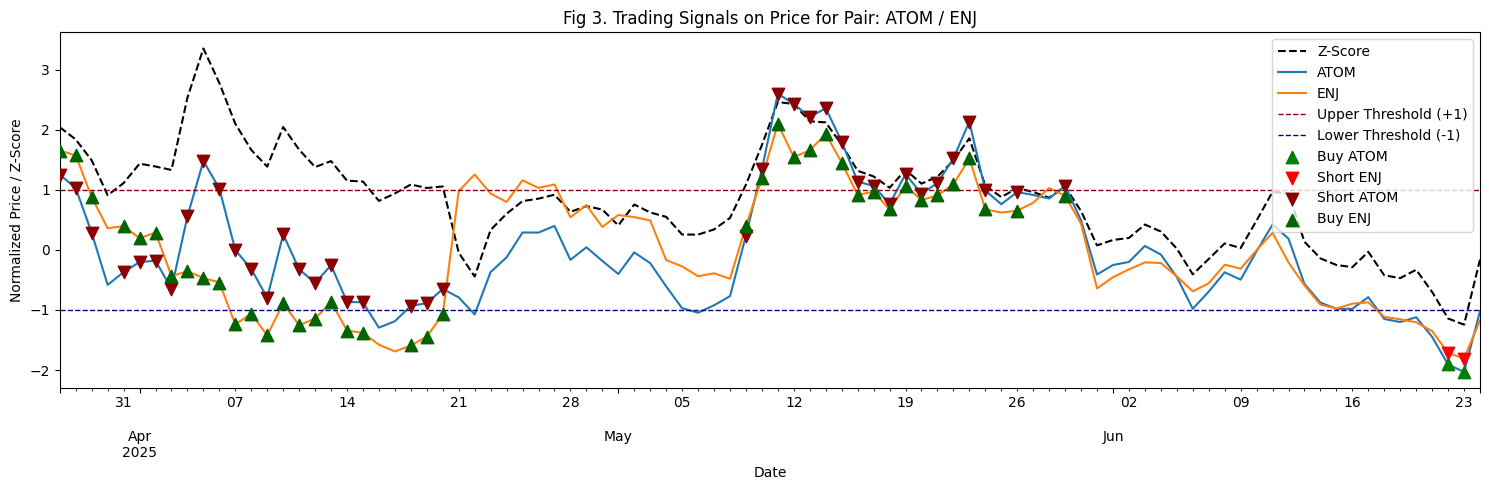

In [244]:
plt.figure(figsize=(20, 3))  # width=12 inches, height=6 inches

pair = tuple(final_pairs[10])
coin1, coin2 = pair
threshold = 1

# Get z-score and coin prices
zscore_series = rolling_params[pair]["rolling_z_score"].loc[test_norm.index]
coin1_series = test_norm[coin1]
coin2_series = test_norm[coin2]

# Define signals
buy_signals = zscore_series[zscore_series < -threshold]   # Buy coin1, short coin2
short_signals = zscore_series[zscore_series > threshold]  # Short coin1, buy coin2

# Plot base
ax = zscore_series.rename("Z-Score").plot(figsize=(15, 5), color="black", linestyle="--")
test_norm[[coin1, coin2]].plot(ax=ax)

# Threshold lines
ax.axhline(threshold, color="darkred", linestyle="--", linewidth=1, label=f"Upper Threshold (+{threshold})")
ax.axhline(-threshold, color="navy", linestyle="--", linewidth=1, label=f"Lower Threshold (-{threshold})")

# BUY SIGNAL (z < -threshold): Buy coin1, Short coin2
ax.scatter(buy_signals.index, coin1_series.loc[buy_signals.index], color='green', marker='^', s=80, label=f"Buy {coin1}", zorder=5)
ax.scatter(buy_signals.index, coin2_series.loc[buy_signals.index], color='red', marker='v', s=80, label=f"Short {coin2}", zorder=5)

# SHORT SIGNAL (z > threshold): Short coin1, Buy coin2
ax.scatter(short_signals.index, coin1_series.loc[short_signals.index], color='darkred', marker='v', s=80, label=f"Short {coin1}", zorder=5)
ax.scatter(short_signals.index, coin2_series.loc[short_signals.index], color='darkgreen', marker='^', s=80, label=f"Buy {coin2}", zorder=5)

# Format plot
ax.set_title(f"Fig 3. Trading Signals on Price for Pair: {coin1} / {coin2}")
ax.set_ylabel("Normalized Price / Z-Score")
ax.set_xlabel("Date")
ax.legend()
plt.tight_layout()
plt.show()

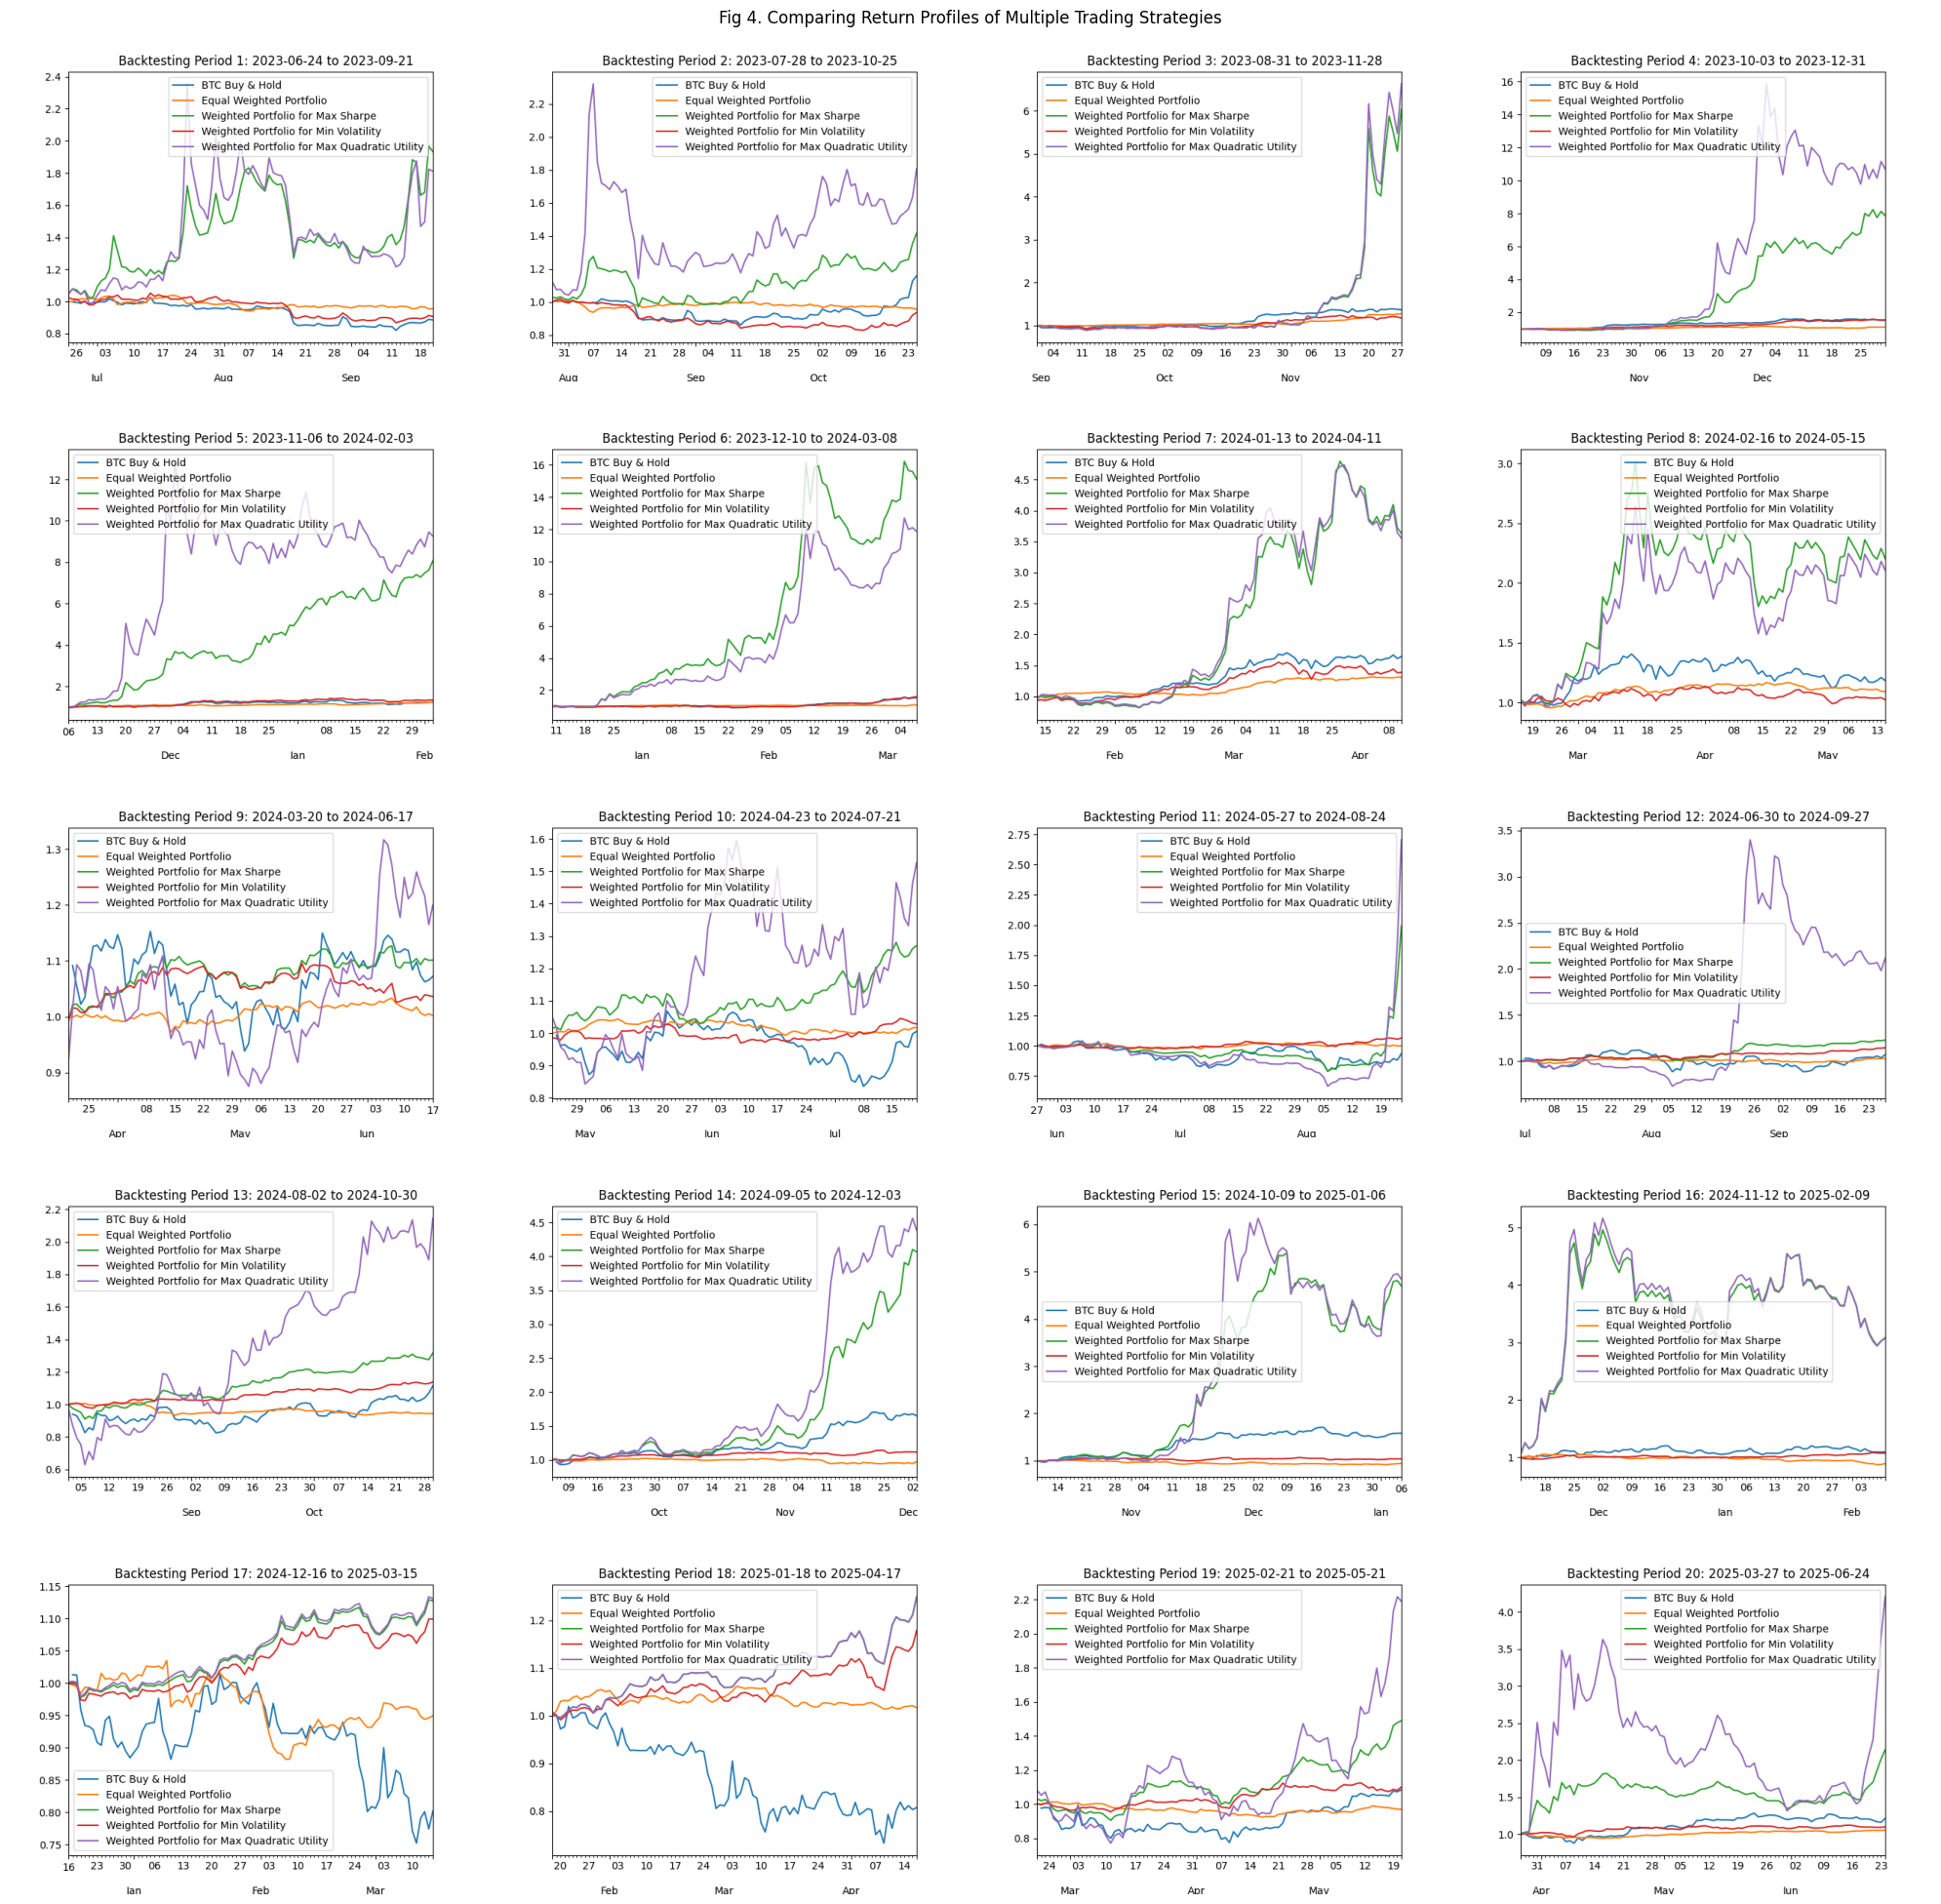

In [243]:
def axes_to_image(ax):
    fig = ax.figure
    canvas = FigureCanvas(fig)  # Attach new canvas
    canvas.draw()
    
    width, height = canvas.get_width_height()
    image = np.frombuffer(canvas.buffer_rgba(), dtype=np.uint8).reshape(height, width, 4)  # RGBA

    return image

# Convert each Axes to image
images = [axes_to_image(ax) for ax in plots]

# Automatically determine layout
n = len(images)
cols = math.ceil(math.sqrt(n))
rows = math.ceil(n / cols)

fig, axes = plt.subplots(cols, rows, figsize=(4 * cols, 5 * rows))
axes = axes.flatten()

for i, img in enumerate(images):
    axes[i].imshow(img)
    axes[i].axis("off")

# Hide extra axes
for j in range(i + 1, len(axes)):
    axes[j].set_visible(False)

plt.suptitle("Fig 4. Comparing Return Profiles of Multiple Trading Strategies")
plt.tight_layout()
plt.show()

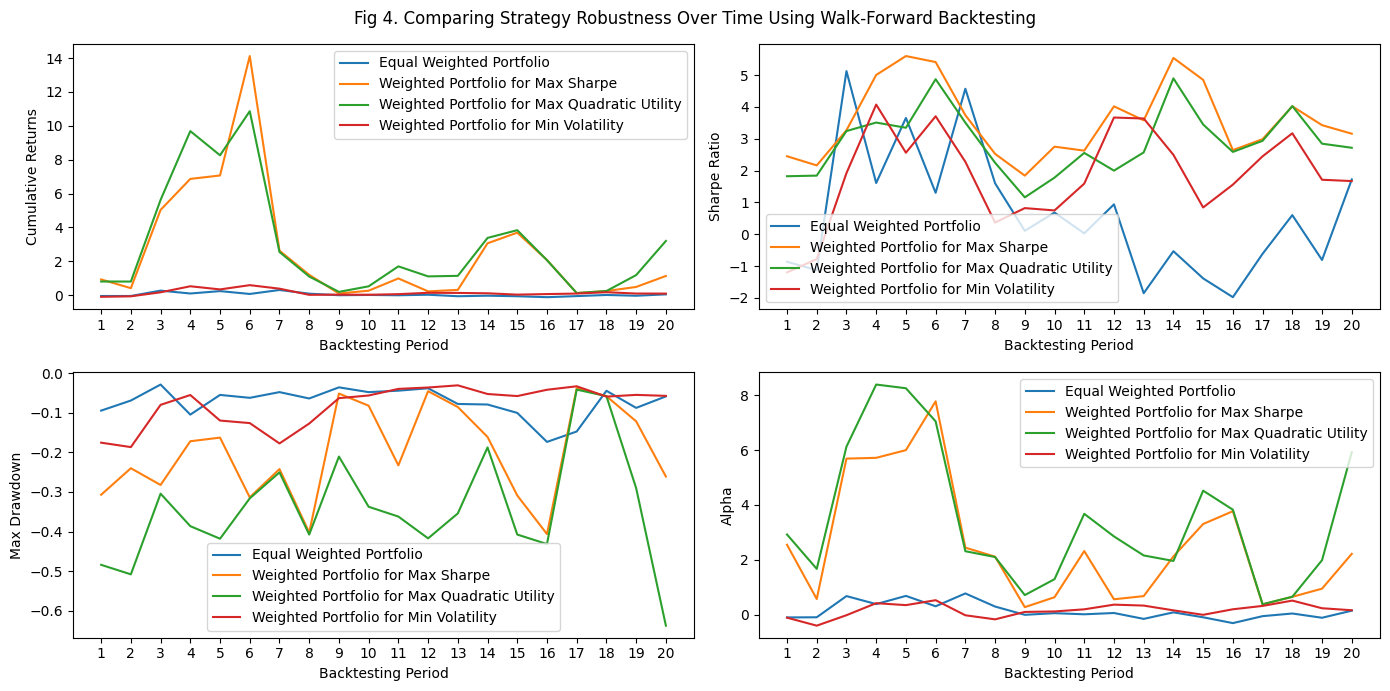

In [111]:
df = pd.concat(performance_stats, axis=0).reset_index()


# Metrics you want to plot
metrics = ["Cumulative Return", "Sharpe Ratio", "Max Drawdown", "Alpha"]
titles = ["Cumulative Returns", "Sharpe Ratio", "Max Drawdown", "Alpha"]
portfolios = [
    "Equal Weighted Portfolio",
    "Weighted Portfolio for Max Sharpe",
    "Weighted Portfolio for Max Quadratic Utility",
    "Weighted Portfolio for Min Volatility"
]

fig, axes = plt.subplots(2, 2, figsize=(14, 7))
axes = axes.flatten()

for ax, metric, title in zip(axes, metrics, titles):
    for port in portfolios:
        (
            df[df["index"] == port][metric]
            .rename(port)
            .reset_index(drop=True)
            .set_axis(pd.Index(range(1, 21)))
            .plot(ax=ax)
        )
    
    ax.set_ylabel(title)
    ax.set_xlabel("Backtesting Period")
    ax.set_xticks(range(1, 21))
    ax.legend()

plt.suptitle("Fig 4. Comparing Strategy Robustness Over Time Using Walk-Forward Backtesting")
fig.tight_layout()
plt.show()